This notebook demonstrates some of the additional functionality of the `GapStat` class, including

- using other clustering algorithms (for using an artibrary clustering algorithm see the the other notebook in the documentation)
- the svd reference distribution
- accessing additional intermediate data computed by GapStat
- other gap maximum estimates
- running with pre-computed cluster estimates for the observed data
- saving a GapStat object
-  loading from pre-computed WCSS

This notebook assumes you are familiar with the basic functionality of GapStat.

In [1]:
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

from clustering.GapStat import GapStat

%matplotlib inline

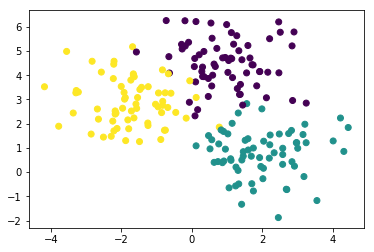

In [2]:
# sample some toy data which will be used for the rest of the notebook
X, y = make_blobs(n_samples=200, centers=3, n_features=2, random_state=0)
plt.scatter(X[:, 0], X[:, 1], c=y)

# arbitrary clustering algorithms

The user can provide an arbitrary clustering algorithm as long as it has been implemented in Python (this is one of the main benefits of this package!)

The package currently implements a few standard clustering algorithms such as K-Means. These can be called by passing a string into the `clusterer` argument (demonstrated below).

In [3]:
gs = GapStat(clusterer='kmeans')
gs.estimate_n_clusters(X)
gs.est_n_clusters

3

#### additional arguments for supplied clustering algorithms

The user can supply additional arguments to customize clusterer via `clusterer_kwargs`. WARNING: `clusterer_kwargs` is only used for one of the pre-implemented clustering algorithms (e.g. if `clusterer` is a stirng).


`clusterer_kwargs` should be a dict mapping key word arguments to their desired values. To find the available key word arguments, see the links in `clusterers.py`. These are genrally just objects from [Sklearn](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.cluster).

In [4]:
# sklearn.cluster.KMeans takes some of the following arguments

clusterer_kwargs = {'init':'random',
                    'n_init':20,
                    'max_iter':100,
                    'random_state':43,
                    'n_jobs':-1,
                    'algorithm':'elkan'}

In [5]:
gs = GapStat(clusterer='kmeans',
             clusterer_kwargs=clusterer_kwargs)

gs.estimate_n_clusters(X)
gs.est_n_clusters

3

`clusterer` can also be a Python function which takes a data matrix and desired number of clusters as input then returns cluster labels for each data point. There is a separate notebook demonstrating this functionality

# SVD reference distribution

In [6]:
gs = GapStat(ref_dist='svd')
gs.estimate_n_clusters(X)

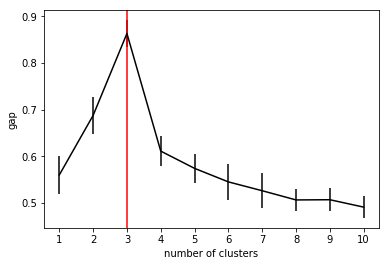

In [7]:
gs.plot_gap()

The user can supply a precomputed SVD of X (e.g. if X is large and the user has already computed it on a cluster)

- Note the gap statistic expects the PCA of X i.e. you should mean center X before computing the SVD (although this is not enforced by the package)

- Note the formatting of the scores, singular values and loadings the package expects. This is slightly different that the default output of some packages. The output should be the same format as  `clustering.utils.svd_wrapper()`. Also see documentaion of `clustering.GapSat.set_svd_decomposition()`.
 

In [8]:
from clustering.utils import svd_wrapper
U, D, V = svd_wrapper(X)

# this equivalent to 
from scipy.linalg import svd
U, D, V = svd(X, full_matrices=False)
V = V.T  # loadings (right singular vectors) are the columns of V!

In [9]:
gs = GapStat(ref_dist='svd')
gs.estimate_n_clusters(X, U=U, D=D, V=V)

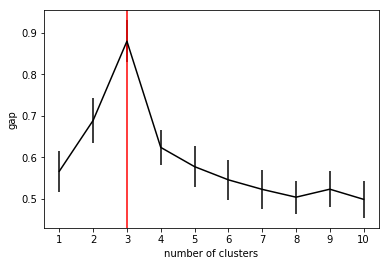

In [10]:
gs.plot_gap()

# access to computed gap statistic attributes

- the gap staistic algorith computes two statistics which we store
    - WCSS of the observed data for each number of clusters (stored as an array called `obs_wcss`)
    - WCSS for each reference distribution, for each number of clusters (stored as a matrix called `null_wcss_samples`)
    
    
- `GapStat` algo gives the user access to
    - Esimated of the expected log(WCSS) of the null distribution. Note this is simply the mean of the log of the null WCSS for a given number of clusters. Can be accessed via a property callled `E_log_null_wcss_est`.
    - The standard deviation of the samples used for the above estimate. Can be accessed via a property callled `E_log_null_wcss_est_sd`.
    - The adjustment factor (called $s_k$ in Tibshirani et al, 2001). Can be accessed via a property called `adj_factor`.
    
    
- While GapStat gives a point estimate of the number of clusters, it also gives a number of possible number of clusters (essentially local maxes of the gap curve).
    - The estimated number of clusters can be accessed via `est_n_clusters` (once this can been computed)
    - A list of possible number of clusters can be accessed via `possible_n_clusters`. This can also be included in the gap plot.
    
    
The code below shows all of this.

In [11]:
gs.obs_wcss

array([ 1325.98445745,   682.08933017,   358.48365669,   305.26190453,
         257.88432498,   219.61757215,   186.85002213,   161.40474421,
         139.15703355,   127.15637421])

In [12]:
gs.null_wcss_samples

array([[ 2383.46666275,  2398.91385904,  2158.33834079,  2404.7850522 ,
         2148.33465972,  2553.80411424,  2342.86518223,  2305.80723379,
         2302.99061747,  2391.29653017],
       [ 1345.0837955 ,  1375.96615451,  1315.11534336,  1440.91902018,
         1231.45002725,  1439.8888966 ,  1366.97640516,  1415.22780011,
         1241.79293011,  1429.29865377],
       [  863.89351647,   886.44628852,   841.54497709,   871.85931682,
          762.55190067,   917.29132597,   903.43501024,   881.07098426,
          829.85794454,   890.13266084],
       [  538.04140579,   580.94450901,   590.08928336,   579.9442967 ,
          527.90864457,   574.29314061,   606.27815389,   552.51563437,
          557.52275727,   593.89464194],
       [  431.03020779,   481.48170726,   453.10914233,   459.03980298,
          420.60720658,   479.17087472,   483.41734126,   453.17844272,
          447.99703018,   490.67639133],
       [  346.00832028,   393.94828988,   375.95648318,   371.8633647 ,
   

In [13]:
gs.E_log_null_wcss_est

array([ 7.75630507,  7.2138761 ,  6.76126007,  6.34498858,  6.12998108,
        5.93761325,  5.75307649,  5.58787192,  5.45879821,  5.34417212])

In [14]:
gs.E_log_null_wcss_est_sd

array([ 0.04908972,  0.05492894,  0.05050087,  0.04252185,  0.0487534 ,
        0.04818212,  0.04687079,  0.03995809,  0.0437406 ,  0.04469023])

In [15]:
gs.adj_factor

1.0488088481701516

In [16]:
gs.est_n_clusters

3

In [17]:
gs.possible_n_clusters

array([ 3.,  4.,  5.,  6.,  7.,  8.,  9.])

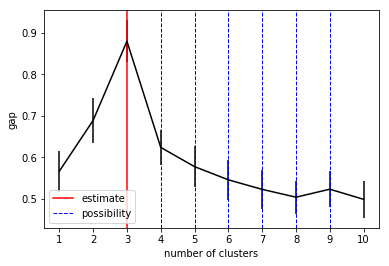

In [18]:
gs.plot_gap(include_possibilities=True)

# other estimates using the gap curve

The original gap statistic paper suggest selecting the number of clusters, K, by
> $\hat{k}$ = the smallest k such that Gap(k) $\ge$ Gap(k + 1) - $s_{k + 1}$
see (Tibshirani et al 2001) for details

We also allow selecting the number of clusters via 
- `firstmax`: the first (i.e. smallest n_clusters) local maxima of the gap statistic

- `globalmax`: the global max of the gap statistic

The [cluster](https://cran.r-project.org/web/packages/cluster/cluster.pdf) (see the `method` argument to `maxSE` on page 18) package in R implements a few more options. Of course the user is welcome to develope their own methodology since they have access to the gap statistics.

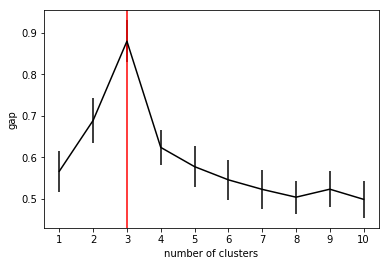

In [19]:
# for this simple dataset, every method gives the same answer
gs.compute_n_cluster_estimate(method='firstmax')
gs.plot_gap()

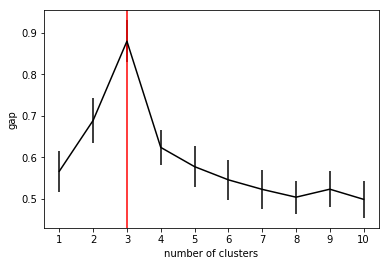

In [20]:
gs.compute_n_cluster_estimate(method='globalmax')
gs.plot_gap()

# pre-computed cluster labels

The user may have pre-computed the clusters for the observed data set. Simply pass these in as an argument to `estimate_n_clusters`.

For example

In [21]:
from sklearn.cluster import KMeans
import numpy as np
cluster_sizes = list(range(1, 11))

obs_cluster_labels = np.zeros((X.shape[0], len(cluster_sizes)))
for i, n_clusters in enumerate(cluster_sizes):
    obs_cluster_labels[:, i] = KMeans(n_clusters=n_clusters).fit_predict(X)
    
    
# obs_cluster_labels should be a matirx of dimensions(num observations x num cluster sizes)
obs_cluster_labels.shape

(200, 10)

In [22]:
gs = GapStat(clusterer='kmeans')
gs.estimate_n_clusters(X, cluster_labels=obs_cluster_labels)
gs.est_n_clusters

3

# save to disk

The user may wish to store the `GapStat` object to disk. 

In [23]:
fname = 'test_file'
gs.save(fname)  # will not include the X data or the SVD by default

In [24]:
gs_loaded = GapStat.load(fname)

In [25]:
gs_loaded.est_n_clusters

3

In [26]:
gs.save(fname, include_data=True) # this will include the X data and the SVD

The user may with to manually parallelize the `GapStat` computation. For example run a fraction of the `B` reference data sets on different nodes.

`GapStat` only needs `cluster_sizes`, `null_wcss_samples`, and `obs_wcss` to fully function. If the user has already computed these, they can initialize `GapStat` using `from_precomputed_wcss`.

# loading from pre-computed WCSS

All GapStat really needs is the WCSS for the observed data and the samples for the reference distribution. We might pre-compute these, for example, using a computing cluster.

In [27]:
cluster_sizes=range(1, 11)

gs_obs = GapStat(cluster_sizes=cluster_sizes)
gs_obs.compute_obs_clusters(X)  # compute the clusters for the observed data
gs_obs.compute_obs_wcss()  # compute the observed wcss

# save these for later
obs_wcss = gs_obs.obs_wcss 
obs_cluster_labels = gs_obs.obs_cluster_labels

In [28]:
# pretend we are computing these on a computing cluster
# so we can do gs1-5 in parallel!

gs1 = GapStat(cluster_sizes=cluster_sizes, B=20)
# this just sets X, cluster_labels and doesn't do any additional computation
gs1.set_obs_clusters(X, cluster_labels=obs_cluster_labels) 
gs1.sample_ref_null_wcss()  # sample B=20 reference distributions

gs2 = GapStat(cluster_sizes=cluster_sizes, B=20)
gs2.set_obs_clusters(X, cluster_labels=obs_cluster_labels) 
gs2.sample_ref_null_wcss()  # sample 20 more reference distributions

gs3 = GapStat(cluster_sizes=cluster_sizes, B=20)
gs3.set_obs_clusters(X, cluster_labels=obs_cluster_labels)
gs3.sample_ref_null_wcss()

gs4 = GapStat(cluster_sizes=cluster_sizes, B=20)
gs4.set_obs_clusters(X, cluster_labels=obs_cluster_labels)
gs4.sample_ref_null_wcss()

gs5 = GapStat(cluster_sizes=cluster_sizes, B=20)
gs5.set_obs_clusters(X, cluster_labels=obs_cluster_labels)
gs5.sample_ref_null_wcss()

In [29]:
# the shape null_wcss_samples is (len(cluster_sizes), B)
gs1.null_wcss_samples.shape

(10, 20)

In [30]:
import numpy as np
null_wcss_samples  = np.concatenate([gs1.null_wcss_samples,
                                     gs2.null_wcss_samples,
                                     gs3.null_wcss_samples,
                                     gs4.null_wcss_samples,
                                     gs5.null_wcss_samples], axis=1)

null_wcss_samples.shape

(10, 100)

In [31]:
# load from pre-computed objects, estimate number of clustesr!
# this does very little computation (i.e. no sampling)
gs = GapStat.from_precomputed_wcss(cluster_sizes=cluster_sizes,
                                   obs_wcss=obs_wcss,
                                   null_wcss_samples=null_wcss_samples)


gs.est_n_clusters

3